In [116]:
F1_SCORE_THRESH = 0.8
USER_ACC = 0.8
USER_LAT = 0.3

# 模拟请求，获取待分析的数据

In [ ]:
import requests
import time
import csv
import os
import datetime

def expr_collect_data():
    sess = requests.Session()

    # expr_name = 'bigger-tom-cpu'
    # expr_name = 'rack-pure-cloud-cpu'
    # expr_name = 'tx2-pure-edge-gpu'
    # expr_name = 'tx2-gpu-rack-cpu'
    # expr_name = 'rack-pure-cloud-cpu-golden'
    # expr_name = 'tx2-pure-edge-gpu-golden'
    # expr_name = 'rack-pure-cloud-gpu-golden'
    # expr_name = 'tx2-pure-edge-cpu-golden'

    expr_name = 'tx2-cloud-gpu-drl+pid'

    # 提交请求
    # node_addr = "127.0.0.1:5001"
    # node_addr = "172.27.152.177:5001"
    # node_addr = "114.212.81.11:5001"
    node_addr = "114.212.81.156:5001"
    query_body = {
        "node_addr": node_addr,
        "video_id": 1,
        "pipeline": ["face_detection", "face_alignment"],
        "user_constraint": {
            "delay": USER_LAT,
            "accuracy": USER_ACC
        }
    }

    # query_addr = "192.168.56.102:5000"
    query_addr = "114.212.81.11:5000"
    # query_addr = "172.27.152.177:5000"
    r = sess.post(url="http://{}/query/submit_query".format(query_addr),
                  json=query_body)
    print('resp:',r.json())
    resp = r.json()
    query_id = resp["query_id"]
    
    # script_name = os.path.basename(__file__).split('.')[0]
    script_name = 'headup_detect_delay_test_ipynb'
    filename = datetime.datetime.now().strftime('%Y%m%d_%H_%M_%S') + \
        '_' + script_name + \
        '_' + str(query_body['user_constraint']['delay']) + \
        '_' + str(query_body['user_constraint']['accuracy']) + \
        '_' + expr_name + \
        '.csv'
    print(filename)
    
    with open(filename, 'w', newline='') as fp:
        fieldnames = ['n_loop', 'frame_id', 'total', 'up', 'fps', 'resolution', 'delay', 'face_detection', 'face_alignment']
        wtr = csv.DictWriter(fp, fieldnames=fieldnames)
        wtr.writeheader()

        written_n_loop = dict()

        # 轮询结果+落盘
        while True:
            r = None
            try:
                time.sleep(1)
                print("post one query request")
                r = sess.get(url="http://{}/query/get_result/{}".format(query_addr, query_id))
                print(f'response:{r.json()}')
                if not r.json():
                    continue
                resp = r.json()

                res_list = resp['appended_result']
                plan = resp['latest_result']['plan']
#                 plan_result = resp['latest_result']['plan_result']

                fps = plan['video_conf']['fps']
                resolution = plan['video_conf']['resolution']
#                 delay = sum(plan_result['delay'].values())

                fd_role = plan['flow_mapping']['face_detection']['node_role']
                fa_role = plan['flow_mapping']['face_alignment']['node_role']

                for res in res_list:
                    n_loop, frame_id, total, up = res['n_loop'], res['frame_id'], res['count_result']['total'], res['count_result']['up']
                    delay = res['delay']
                    row = {
                        # task result
                        'n_loop': n_loop,
                        'frame_id': frame_id,
                        'total': total,
                        'up': up,
                        
                        # runtime info (expect content-aware)
                        'delay': delay,
                        
                        # scheduling plan
                        'fps': fps,
                        'resolution': resolution,
                        'face_detection': fd_role,
                        'face_alignment': fa_role
                    }
                    if n_loop not in written_n_loop:
                        wtr.writerow(row)
                        written_n_loop[n_loop] = 1
                    
                print("written one query response, len written_n_loop={}".format(len(written_n_loop.keys())))

            except Exception as e:
                if r:
                    print("got serv result: {}".format(r.text))
                print("caught exception: {}".format(e), exc_info=True)
                break

# 分析数据

## 概览

In [117]:
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import sklearn.metrics
plt.rcParams['font.sans-serif'] = ['SimHei']

In [118]:
max_fps = 30
resolution_map = {"360p": 0, "480p": 1, "720p": 2, "1080p": 3}
GT_DF_FILENAME = '20230606_16_49_35_headup_detect_delay_test_0.3_0.9_rack-pure-cloud-gpu-golden.csv'
ACT_DF_FILENAME = '20231121_16_27_47_headup_detect_delay_test_ipynb_0.3_0.9_tx2-cloud-gpu-drl+pid.csv'
ACT_DF_ST_ED_ROW = 800

In [119]:
df = pd.read_csv(ACT_DF_FILENAME)

df = df[1:ACT_DF_ST_ED_ROW]
df.loc[df['fps'] >= 30, 'fps'] = max_fps
df['resolution'] = df['resolution'].replace(resolution_map)

df

df_golden = pd.read_csv(GT_DF_FILENAME)
gt_res = df_golden[['frame_id', 'delay']].copy()
act_res = df[['frame_id', 'delay']].copy()
matched_df = pd.merge(gt_res, act_res, on=['frame_id'], how='left').fillna(method='ffill').fillna(method='bfill')

matched_df

,frame_id,delay_x,delay_y
0,1.0,0.129305,0.231592
1,2.0,0.129305,0.231592
2,3.0,0.129305,0.237128
3,4.0,0.130046,0.265023
4,5.0,0.130046,0.265023
...,...,...,...
832,833.0,0.219581,0.167254
833,834.0,0.219581,0.167254
834,835.0,0.218297,0.082278
835,836.0,0.218297,0.082278


In [120]:
df

,n_loop,frame_id,total,up,fps,resolution,delay,face_detection,face_alignment
1,2,2.0,7,6,30,1,0.231592,host,host
2,3,3.0,7,6,20,1,0.237128,host,host
3,4,4.0,7,7,20,1,0.265023,host,host
4,5,7.0,7,6,20,1,0.127909,host,host
5,6,8.0,7,6,20,1,0.233503,host,host
...,...,...,...,...,...,...,...,...,...
722,723,1131.0,11,10,30,3,0.202963,cloud,cloud
723,724,1132.0,11,7,30,3,0.182318,cloud,cloud
724,725,1133.0,12,9,30,3,0.193627,cloud,cloud
725,726,1134.0,12,8,30,3,0.187452,cloud,cloud


No handles with labels found to put in legend.


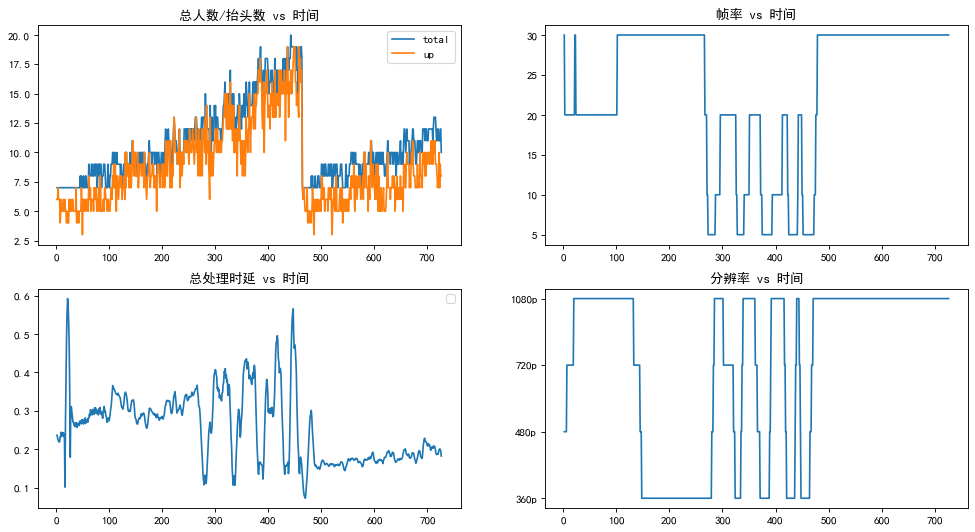

In [121]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), dpi=80)
axs[0,0].plot(df['n_loop'], df['total'], label='total')
axs[0,0].plot(df['n_loop'], df['up'], label='up')
axs[0,0].title.set_text('总人数/抬头数 vs 时间')
axs[0,0].legend()

plot_range = range(1, len(df['n_loop']))

# axs[1,0].hlines(y=0.3, xmin=0, xmax=len(df['n_loop']), linewidth=3, color='r', label='用户约束')
axs[1,0].plot(df['n_loop'][plot_range], scipy.signal.savgol_filter(df['delay'][plot_range], 11, 3))
# axs[1,0].plot(df['n_loop'], df['delay'])
# axs[1,0].hlines(y=0.3, xmin=0, xmax=len(matched_df['frame_id']), linewidth=3, color='r', label='用户约束')
# axs[1,0].plot(matched_df['frame_id'], scipy.signal.savgol_filter(matched_df['delay_y'], 11, 3))
axs[1,0].title.set_text('总处理时延 vs 时间')
axs[1,0].legend()


axs[0,1].plot(df['n_loop'][plot_range], df['fps'][plot_range])
axs[0,1].title.set_text('帧率 vs 时间')

axs[1,1].set_yticks(np.arange(4))
axs[1,1].set_yticklabels(resolution_map.keys())
axs[1,1].plot(df['n_loop'][plot_range], df['resolution'][plot_range])
axs[1,1].title.set_text('分辨率 vs 时间')

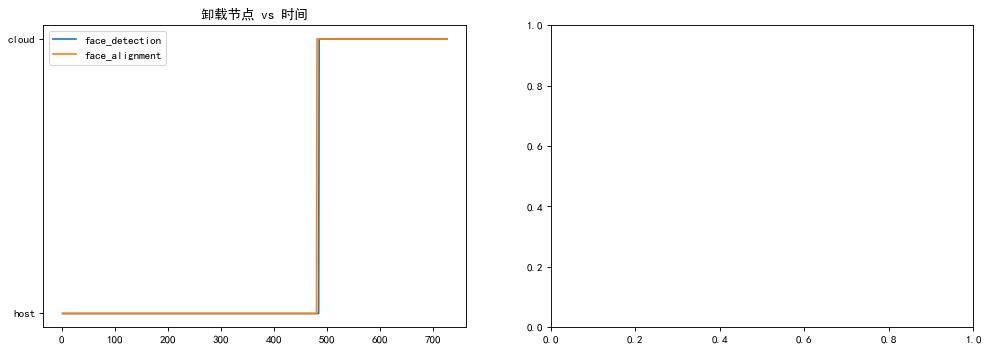

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=80)
axs[0].plot(df['n_loop'], df['face_detection'], label='face_detection')
axs[0].plot(df['n_loop'], df['face_alignment'], label='face_alignment')
axs[0].title.set_text('卸载节点 vs 时间')
axs[0].legend()

## 与黄金配置比较

In [123]:
df = pd.read_csv(ACT_DF_FILENAME)

df_golden = pd.read_csv(GT_DF_FILENAME)


def pre_treat(df, st_row, ed_row):    
    df = df[st_row: ed_row]

    max_fps = 30
    df.loc[df['fps'] >= 30, 'fps'] = max_fps
    resolution_map = {"360p": 0, "480p": 1, "720p": 2, "1080p": 3}
    df['resolution'] = df['resolution'].replace(resolution_map)
    
    return df

df = pre_treat(df, st_row=1, ed_row=ACT_DF_ST_ED_ROW)
df_golden = pre_treat(df_golden, st_row=1, ed_row=len(df_golden))
gt_res = df_golden[['frame_id', 'total', 'up']].copy()

C:\P\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\Peng_\AppData\Local\Temp/ipykernel_21936/3771942515.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['resolution'] = df['resolution'].replace(resolution_map)


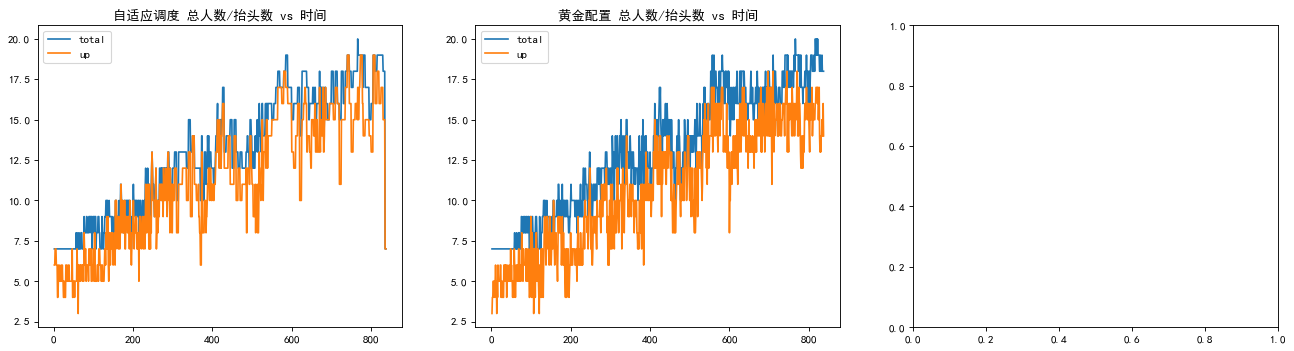

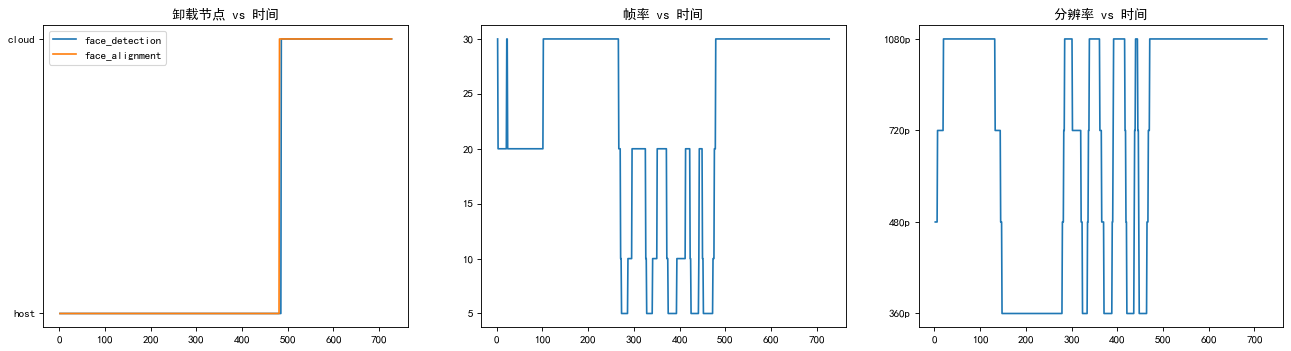

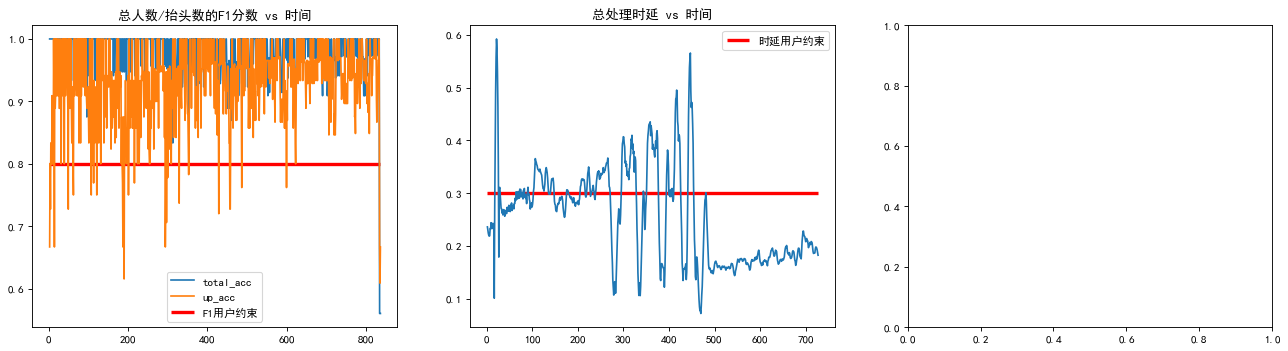

In [124]:
gt_res = df_golden[['frame_id', 'total', 'up']].copy()
act_res = df[['frame_id', 'total', 'up']].copy()
matched_df = pd.merge(gt_res, act_res, on=['frame_id'], how='left').fillna(method='ffill').fillna(method='bfill')

def get_f1(matched_df, true_col, pred_col):
    TP = matched_df[[true_col, pred_col]].min(axis=1)
    FP = matched_df[pred_col] - TP
    FN = matched_df[true_col] - TP
    PRECISION = (TP) / (TP + FP)
    RECALL = (TP) / (TP + FN)
#     return RECALL
    return 2 * (RECALL * PRECISION) / (RECALL + PRECISION)

matched_df['total_f1'] = get_f1(matched_df, 'total_x', 'total_y')
matched_df['up_f1'] = get_f1(matched_df, 'up_x', 'up_y')

# 检测结果
fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=80)

# axs[0].plot(df['n_loop'], df['total'], label='total')
# axs[0].plot(df['n_loop'], df['up'], label='up')
axs[0].plot(matched_df['frame_id'], matched_df['total_y'], label='total')
axs[0].plot(matched_df['frame_id'], matched_df['up_y'], label='up')
axs[0].title.set_text('自适应调度 总人数/抬头数 vs 时间')
axs[0].legend()

axs[1].plot(df_golden['n_loop'], df_golden['total'], label='total')
axs[1].plot(df_golden['n_loop'], df_golden['up'], label='up')
axs[1].title.set_text('黄金配置 总人数/抬头数 vs 时间')
axs[1].legend()



# 调度策略
fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=80)
axs[0].plot(df['n_loop'], df['face_detection'], label='face_detection')
axs[0].plot(df['n_loop'], df['face_alignment'], label='face_alignment')
axs[0].title.set_text('卸载节点 vs 时间')
axs[0].legend()


axs[1].plot(df['n_loop'], df['fps'])
axs[1].title.set_text('帧率 vs 时间')

axs[2].set_yticks(np.arange(4))
axs[2].set_yticklabels(resolution_map.keys())
axs[2].plot(df['n_loop'], df['resolution'])
axs[2].title.set_text('分辨率 vs 时间')


# 精度&时延情况
fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=80)

axs[0].hlines(y=USER_ACC, xmin=0, xmax=len(matched_df['frame_id']), linewidth=3, color='r', label='F1用户约束')
axs[0].plot(matched_df['frame_id'], matched_df['total_f1'], label='total_acc')
axs[0].plot(matched_df['frame_id'], matched_df['up_f1'], label='up_acc')
axs[0].title.set_text('总人数/抬头数的F1分数 vs 时间')
axs[0].legend()

axs[1].hlines(y=USER_LAT, xmin=0, xmax=len(df['n_loop']), linewidth=3, color='r', label='时延用户约束')
axs[1].plot(df['n_loop'], scipy.signal.savgol_filter(df['delay'], 11, 3))
# axs[1,0].plot(df['n_loop'], df['delay'])
axs[1].title.set_text('总处理时延 vs 时间')
axs[1].legend()


In [103]:
print("F1_SCORE_THRESH {}, USER_ACC {}".format(F1_SCORE_THRESH, USER_ACC))
longterm_acc_total = len(matched_df.loc[matched_df['total_f1'] > F1_SCORE_THRESH]) / len(matched_df)
longterm_acc_up = len(matched_df.loc[matched_df['up_f1'] > F1_SCORE_THRESH]) / len(matched_df)
print("longterm_acc: ")
print("[total] {} [up] {}".format(longterm_acc_total, longterm_acc_up))

F1_SCORE_THRESH 0.8, USER_ACC 0.8
longterm_acc: 
[total] 0.29784688995215314 [up] 0.44138755980861244


In [47]:
matched_df

,frame_id,total_x,up_x,total_y,up_y,total_f1,up_f1
0,2.0,7,3,7.0,6.0,1.000000,0.666667
1,3.0,7,4,7.0,6.0,1.000000,0.800000
2,4.0,7,4,7.0,7.0,1.000000,0.727273
3,5.0,7,5,7.0,7.0,1.000000,0.833333
4,6.0,7,5,7.0,7.0,1.000000,0.833333
...,...,...,...,...,...,...,...
831,833.0,19,15,19.0,17.0,1.000000,0.937500
832,834.0,18,14,19.0,17.0,0.972973,0.903226
833,835.0,18,14,19.0,17.0,0.972973,0.903226
834,836.0,18,16,19.0,17.0,0.972973,0.969697


# CPU和GPU精度对比

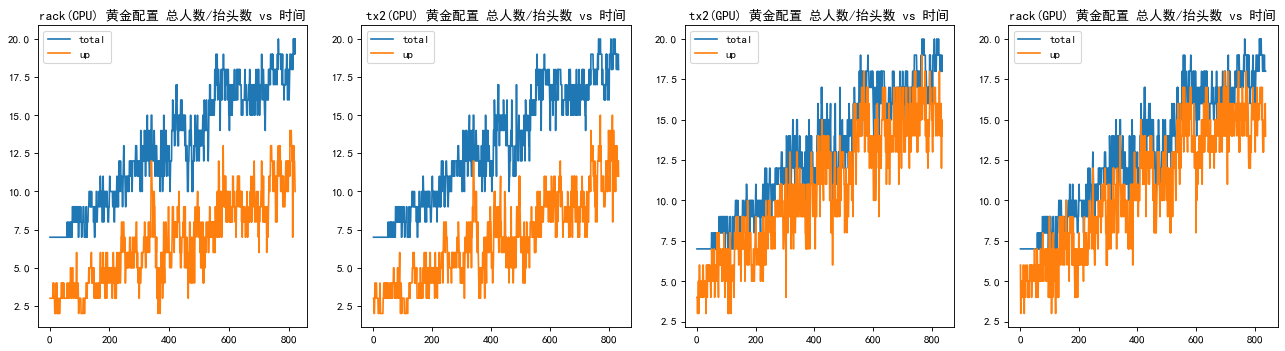

In [154]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=80)

def plot_golden_in_axs(idx, axs, df, text):
    axs[idx].plot(df['n_loop'], df['total'], label='total')
    axs[idx].plot(df['n_loop'], df['up'], label='up')
    axs[idx].title.set_text(text + ' 黄金配置 总人数/抬头数 vs 时间')
    axs[idx].legend()

df = pd.read_csv('20230606_14_07_27_headup_detect_delay_test_0.3_0.9_rack-pure-cloud-cpu-golden.csv')
plot_golden_in_axs(0, axs, df, text='rack(CPU)')
df = pd.read_csv('20230606_17_10_02_headup_detect_delay_test_0.3_0.9_tx2-pure-edge-cpu-golden.csv')
plot_golden_in_axs(1, axs, df, text='tx2(CPU)')
df = pd.read_csv('20230606_16_28_39_headup_detect_delay_test_0.3_0.9_tx2-pure-edge-gpu-golden.csv')
plot_golden_in_axs(2, axs, df, text='tx2(GPU)')
df = pd.read_csv('20230606_16_49_35_headup_detect_delay_test_0.3_0.9_rack-pure-cloud-gpu-golden.csv')
plot_golden_in_axs(3, axs, df, text='rack(GPU)')

In [24]:

range(150)

range(0, 150)